In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt

In [2]:
#from DA_PoC.dynamical_systems.sw_numerical_model 
from DA_PoC.dynamical_systems.examples.sw import SWModelJax
from DA_PoC.common.numerical_model import NumericalModel

from DA_PoC.common.observation_operator import LinearObservationOperator
import numpy as np

In [3]:
n_x = 32
dx = 5e3
n_y = 32
dy = 5e3
swmodel = SWModelJax(n_x, dx, n_y, dy, periodic_x=True)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
state_dimension = 3 * swmodel.state_variable_length
obs_dimension = swmodel.state_variable_length
h_no_nan = np.eye(swmodel.state_variable_length)
for i in range(swmodel.state_variable_length):
    if i % 32 == 0:
        h_no_nan[i, i] = 0
        h_no_nan[i-1, i-1] = 0

H_obs = np.hstack(
    [
        np.zeros((swmodel.state_variable_length, swmodel.state_variable_length)),
        np.zeros((swmodel.state_variable_length, swmodel.state_variable_length)),
        h_no_nan,
    ]
)
obs_operator = LinearObservationOperator(Hmatrix=H_obs)
window = 15
# print(f"{lorenz.obs.shape=}")
# print(f"{lorenz.H=}")
numerical_model_sw = NumericalModel(state_dimension, obs_dimension)
background = np.zeros(state_dimension)
background[swmodel.slice_h] = swmodel.depth
numerical_model_sw.background = background
numerical_model_sw.background_error_cov_inv = 20 * np.eye(state_dimension)
numerical_model_sw.set_observation_operator(obs_operator)
def remove_nan(array):
    return np.where(np.isnan(array), 0, array)
numerical_model_sw.set_forward(lambda x: remove_nan(swmodel.forward(x, n_steps=window, pbar=False)))
numerical_model_sw.set_tangent_linear(
    lambda x: np.asarray(swmodel.forward_TLM(x, n_steps=window)[0])
)
x0_t = background
x0_t[swmodel.slice_h] += 3 * np.random.randn(swmodel.state_variable_length)

Observation operator set already


In [5]:
# new_state = numerical_model_sw.forward_no_obs(x0_t)
def generate_obs_no_noise(x0, n_steps):
    return remove_nan(swmodel.forward(x0, n_steps=n_steps)[swmodel.slice_h])

true_obs = generate_obs_no_noise(x0_t, window)


16it [00:02,  5.96it/s]                        


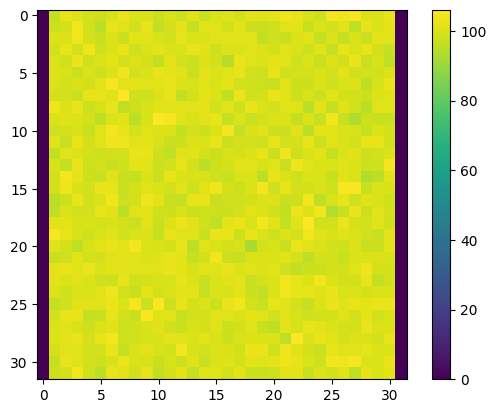

In [6]:
plt.imshow(true_obs.reshape(32, 32))
plt.colorbar()

In [7]:
true_obs

array([  0.      ,  96.234474, 102.56745 , ...,  99.98112 , 101.672844,
         0.      ], dtype=float32)

In [8]:
noisy_obs = true_obs +  np.random.normal(loc=0, scale=0.1, size=true_obs.shape)

In [9]:
numerical_model_sw.set_obs(noisy_obs)
print(numerical_model_sw.cost_function(x0_t + np.random.normal(size=x0_t.shape)))
print(numerical_model_sw.cost_function(x0_t))

33834.8246580102
5.2832569184551375


In [10]:
numerical_model_sw.cost_function(x0_t)
grad = numerical_model_sw.gradient(x0_t)

16it [00:11,  1.43it/s]                        


16it [00:10,  1.51it/s]                        


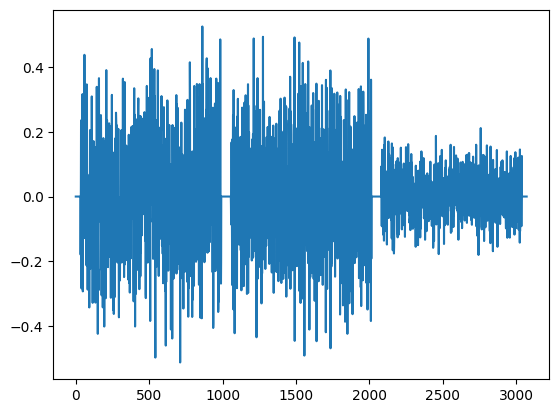

In [11]:
cost = numerical_model_sw.cost_function(x0_t)
grad = numerical_model_sw.gradient(x0_t)
plt.plot(grad)

16it [00:10,  1.50it/s]                        


32418.227816598017


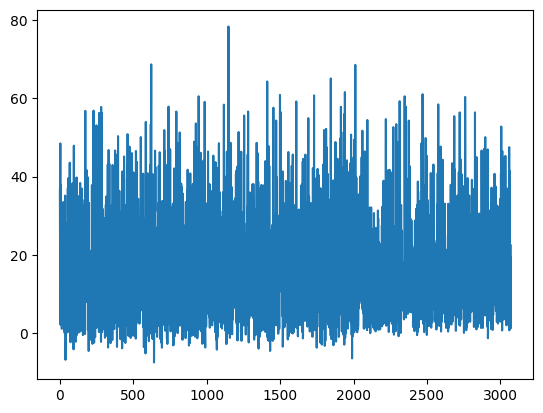

In [12]:
x1 = x0_t + np.abs(np.random.normal(size=x0_t.shape))
cost_bck = numerical_model_sw.cost_function(x1)
grad_bck = numerical_model_sw.gradient(x1)
plt.plot(grad_bck)
print(cost_bck)

In [13]:
cost_bck

32418.227816598017

In [14]:
cost

5.2832569184551375

In [15]:
np.linalg.norm(grad_bck), np.linalg.norm(grad)

(1175.9254643754755, 7.403223669288403)

In [16]:
gn = numerical_model_sw.gauss_newton_hessian_matrix(x1)

16it [00:10,  1.46it/s]                        


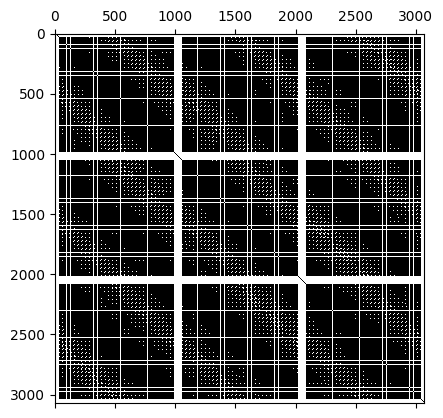

In [17]:
plt.set_cmap("magma")
plt.spy(gn)

In [18]:
np.linalg.cond(gn)

1.7970540758066502

In [19]:
np.sqrt(x0_t.size)

55.42562584220407

In [20]:
np.sqrt(state_dimension / 3)

32.0

In [21]:
import os
os.getcwd()
import datetime

'/DA_PoC/notebooks'

In [22]:
exp_name =datetime.strtime("%H:%M:%S")
gn_result = numerical_model_sw.GNmethod(x1, verbose=True, prec=None, log_file=os.path.join(os.getcwd(), 'log_sw.txt'), exp_name="sw", i_cycle=0)

    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


16it [00:10,  1.47it/s]                        
16it [00:10,  1.53it/s]                        
16it [00:10,  1.53it/s]                        
16it [00:10,  1.46it/s]                        


      sw,     0,     0, 32418.2278,       10, 9428.83, 1.797e+00, 1.797e+00


16it [00:10,  1.50it/s]                        
16it [00:10,  1.50it/s]                        
16it [00:10,  1.50it/s]                        
16it [00:10,  1.49it/s]                        


In [ ]:
Jo = numerical_model_sw.data_misfit(x1)
Jb = numerical_model_sw.background_cost(x1)

In [ ]:
print( 0.5 *(Jo.T @ Jo))
print(Jb)

3.0883274411088877
1.3007028602857338


In [ ]:
gn_x = gn_result['gn_x']

3.7386788712517545
4.619653741089994


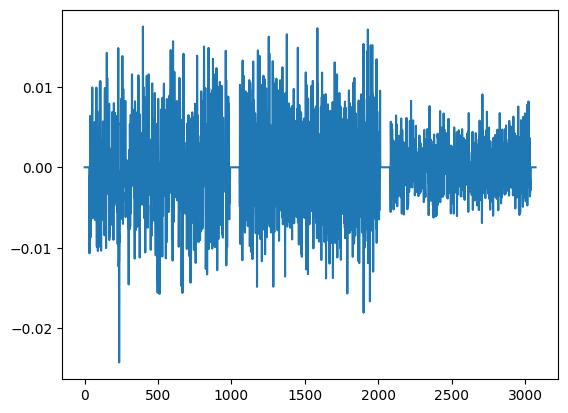

In [ ]:
plt.plot(background - gn_x)
print(numerical_model_sw.cost_function(gn_x))
print(numerical_model_sw.cost_function(background))


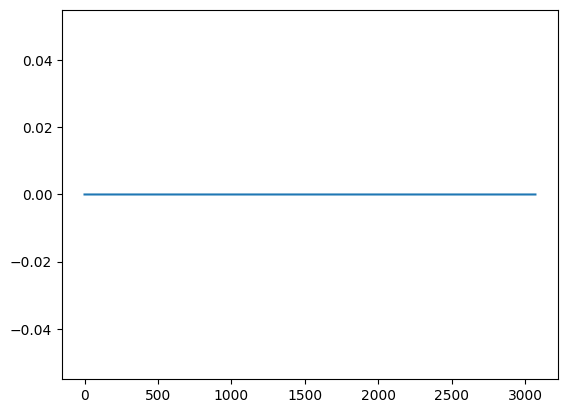

In [ ]:
plt.plot(gn_x - x1)